<center>
    
# [Компьютерное зрение](https://cogmodel.mipt.ru/wiki/index.php/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5)

## <center> Семинар 9 - Текстурный анализ изображений
***

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage
from skimage import feature
from skimage.transform import integral_image
import ipywidgets

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from tqdm import tqdm

# Загрузка данных

Теоретические материалы можно найти на слайдах лекции на [странице курса](https://cogmodel.mipt.ru/wiki/index.php/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5).

В рамках данного семинара предлагается поработать с набором данных **Describable Textures Dataset (DTD)** - https://www.robots.ox.ac.uk/~vgg/data/dtd/. Основным заданием будет решить задачу классификации текстур на основе текстурных признаков основанных на полутоновой матрице смежности (GLCM, Grey-Level Co-occurence Matrix).

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

--2023-04-19 14:26:49--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/dtd/dtd-r1.0.1.tar.gz [following]
--2023-04-19 14:26:50--  https://thor.robots.ox.ac.uk/datasets/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/octet-stream]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  7.66MB/s    in 65s     

2023-04-19 14:27:57 (9.20 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



In [3]:
!tar -xvf dtd-r1.0.1.tar.gz

Streaming output truncated to the last 5000 lines.
dtd/images/porous/porous_0122.jpg
dtd/images/porous/porous_0156.jpg
dtd/images/porous/porous_0091.jpg
dtd/images/porous/porous_0083.jpg
dtd/images/porous/porous_0124.jpg
dtd/images/porous/porous_0151.jpg
dtd/images/porous/porous_0131.jpg
dtd/images/porous/porous_0096.jpg
dtd/images/porous/porous_0153.jpg
dtd/images/porous/porous_0154.jpg
dtd/images/porous/porous_0052.jpg
dtd/images/porous/porous_0172.jpg
dtd/images/porous/porous_0044.jpg
dtd/images/porous/porous_0118.jpg
dtd/images/porous/porous_0140.jpg
dtd/images/porous/porous_0152.jpg
dtd/images/porous/porous_0171.jpg
dtd/images/porous/porous_0132.jpg
dtd/images/porous/porous_0105.jpg
dtd/images/porous/porous_0127.jpg
dtd/images/porous/porous_0130.jpg
dtd/images/porous/porous_0104.jpg
dtd/images/porous/porous_0066.jpg
dtd/images/porous/porous_0158.jpg
dtd/images/porous/porous_0128.jpg
dtd/images/porous/porous_0138.jpg
dtd/images/porous/porous_0133.jpg
dtd/images/porous/porous_0050.j

In [4]:
img = cv2.imread('dtd/images/lined/lined_0039.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

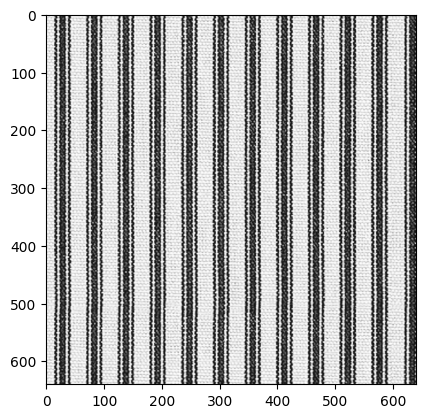

In [5]:
plt.imshow(img_gray, cmap='Greys_r')

# GLCM - Gray Level Co-Occurrence Matrix

Реализацию расчета GLCM и некоторых признаков можно взять из библиотеки skimage:

In [6]:
import skimage.feature as feature

interactive(children=(IntSlider(value=1, description='distance', min=1), IntSlider(value=0, description='angle…

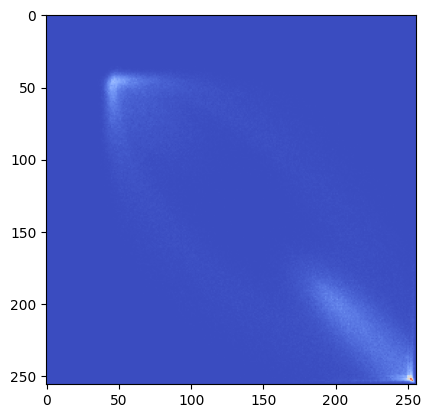

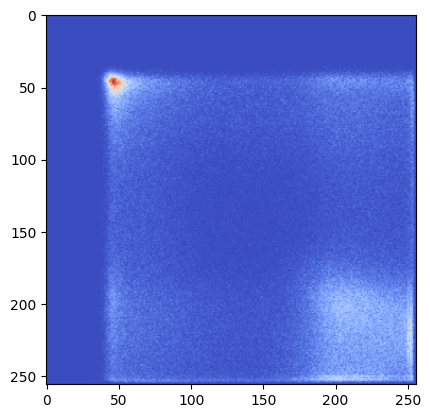

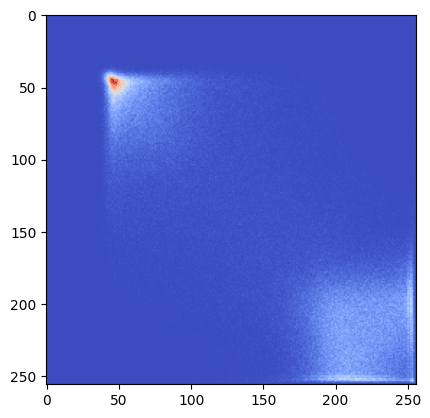

In [8]:
@ipywidgets.interact(
    distance=ipywidgets.IntSlider(min=1, max=100, step=1, value=1),
    angle=ipywidgets.IntSlider(min=-180, max=180, step=1, value=0)
)
def play_with_glcm(distance, angle):
    glcm = feature.greycomatrix(img_gray, [distance], [angle * np.pi / 180], levels=256)
    plt.imshow(glcm[:, :, 0, 0], cmap='coolwarm')

## Вопрос 1

Как по полутоновой матрице смежности определить период текстуры? Чему примерно он равен на рисунке выше (вдоль оси X)?

**Ответ:** Базируясь на том, что период текстуры должен сохраняться вдоль оси поворота (=$n\frac{\pi}{2}, n \in \mathbb{Z}$) – тогда вдоль периода при смещении будет яркое пятно или полоса на диаграмме. Подбором видно, что он примерно равен 50 (48-49).

## Вычисление характеристик

- `'contrast'`: $$\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$$
- `'dissimilarity'`: $$\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$$
- `'homogeneity'`: $$\sum_{i,j=0}^{levels-1}\frac{P_{i,j}}{1+(i-j)^2}$$
- `'ASM'`: $$\sum_{i,j=0}^{levels-1} P_{i,j}^2$$
- `'energy'`: $$\sqrt{ASM}$$
- `'correlation'`: $$\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i)(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$$

In [ ]:
glcm = skimage.feature.graycomatrix(img_gray, [50], [0], levels=256)

contrast = skimage.feature.graycoprops(glcm, 'contrast')[0][0]
dissimilarity = skimage.feature.graycoprops(glcm, 'dissimilarity')[0][0]
homogeneity = feature.graycoprops(glcm, 'homogeneity')[0][0]
energy = feature.graycoprops(glcm, 'energy')[0][0]
correlation = feature.graycoprops(glcm, 'correlation')[0][0]
ASM = feature.graycoprops(glcm, 'ASM')[0][0]

print("Contrast: {}".format(contrast))
print("Dissimilarity: {}".format(dissimilarity))
print("Homogeneity: {}".format(homogeneity))
print("Energy: {}".format(energy))
print("Correlation: {}".format(correlation))
print("ASM: {}".format(ASM))

Contrast: 8769.00970868644
Dissimilarity: 69.9390625
Homogeneity: 0.023887953463630974
Energy: 0.006905359909839269
Correlation: 0.15376944652402255
ASM: 4.76839954844154e-05


# Классификация текстур

Сначала определим функцию для загрузки датасета, которая для каждого изображения сразу расчитает его набор признаков:

In [ ]:
def load_dtd(path, get_features_fn):
    classes = sorted(os.listdir(os.path.join(path, 'images')))

    rows = []
    name2idx = {}

    for class_name in tqdm(classes):
        folder_path = os.path.join(path, 'images', class_name)
        for img_name in os.listdir(folder_path):
            if not img_name.endswith('.jpg'):
                continue

            img_path = os.path.join(folder_path, img_name)

            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            features = get_features_fn(img_gray)

            features['class'] = class_name

            name2idx[img_name] = len(rows)
            rows.append(features)
    
    splits = []

    for split in range(1, 11):
        train_filepath = os.path.join(path, 'labels', 'train{}.txt'.format(split))
        val_filepath = os.path.join(path, 'labels', 'val{}.txt'.format(split))
        test_filepath = os.path.join(path, 'labels', 'test{}.txt'.format(split))

        with open(train_filepath) as f:
            train_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        with open(val_filepath) as f:
            val_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        with open(test_filepath) as f:
            test_ids = list(map(lambda x: name2idx[x.split('/')[-1]], f.read().split()))

        splits.append((train_ids, val_ids))

    return pd.DataFrame(rows), splits

In [ ]:
from skimage.filters import gabor_kernel
import scipy

В качестве примера определим функцию, возвращающую доступные в skimage текстурные характеристики:

In [ ]:
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in [1, 3]:
        for frequency in [0.05, 0.25, 0.5]:
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                        sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


def autocorrelation(matrix):
    num_level = len(matrix)
    I, J = np.ogrid[0:num_level, 0:num_level]
    weights = I * J
    weights = weights.reshape((num_level, num_level, 1, 1))
    results = np.apply_over_axes(np.sum, (matrix * weights), axes=(0, 1))[0, 0]
    return results

def shadow(matrix):
    num_level, num_level1, num_dist, num_angle = matrix.shape

    I = np.array(range(num_level)).reshape((num_level, 1, 1, 1))
    J = np.array(range(num_level)).reshape((1, num_level, 1, 1))
    diff_i = np.apply_over_axes(np.sum, (I * matrix), axes=(0, 1))[0, 0]
    diff_j = np.apply_over_axes(np.sum, (J * matrix), axes=(0, 1))[0, 0]

    results = np.apply_over_axes(np.sum, np.power(matrix * (I + J - (diff_i + diff_j)), 3),
                                 axes=(0, 1))[0, 0]
    return results

def max_prob(matrix):
    num_level, num_level1, num_dist, num_angle = matrix.shape

    results = np.apply_over_axes(np.max, 
                                 matrix,
                                 axes=(0, 1))[0, 0]
    return results

def get_features(img_gray):
    dists = [0, 1, 2, 4, 5, 50]
    angles = [0, np.pi/2, np.pi/4, 3 * np.pi/4]

    props = ['contrast', 'dissimilarity', 'homogeneity', 
             'energy', 'correlation', 'ASM', autocorrelation, shadow, max_prob]

    graycom = feature.graycomatrix(img_gray, dists, angles, levels=256, normed = True, symmetric=True)
    img_gray = (img_gray - img_gray.mean()) / img_gray.std()

    def compute_feats(image, kernels):
        feats = {}
        for k, kernel in enumerate(kernels):
            filtered = scipy.ndimage.convolve(image, kernel, mode='wrap')
            #heuristic hmhmhmhmh
            feats[f"habor_kernel_{k}_mean"] = filtered.mean(axis=(0,1))
            feats[f"habor_kernel_{k}_std"] = filtered.var(axis=(0,1))

        return feats

    features = {}
    freqs = np.fft.fft2(img_gray)

    features["fft_abs_mean"] = np.abs(freqs).mean(axis=(0,1))
    features["fft_abs_std"] = np.abs(freqs).var(axis=(0,1))
    
    features["fft_angle"] = np.angle(freqs).mean(axis=(0,1))
    features.update(compute_feats(img_gray, kernels))

    for prop in props:
        if isinstance(prop, str):
            prop_values = feature.graycoprops(graycom, prop)
            prop_name = prop
        else: 
            prop_values = prop(graycom)
            prop_name = prop.__name__

        for i, dist in enumerate(dists):
            for j, angle in enumerate(angles):
                features[prop_name + '_{:.3f}_{:.3f}'.format(dist, angle)] = prop_values[i, j]
    
    return features

In [ ]:
df, splits = load_dtd('dtd', get_features)

100%|██████████| 47/47 [2:35:03<00:00, 197.94s/it]


In [ ]:
df.head()

,fft_abs_mean,fft_abs_std,fft_angle,habor_kernel_0_mean,habor_kernel_0_std,habor_kernel_1_mean,habor_kernel_1_std,habor_kernel_2_mean,habor_kernel_2_std,habor_kernel_3_mean,...,max_prob_4.000_2.356,max_prob_5.000_0.000,max_prob_5.000_1.571,max_prob_5.000_0.785,max_prob_5.000_2.356,max_prob_50.000_0.000,max_prob_50.000_1.571,max_prob_50.000_0.785,max_prob_50.000_2.356,class
0,11.422491,255869.526693,0.004287,-4.163336e-16,0.740145,-1.208877e-16,0.112943,-1.214306e-17,0.019840,-2.386980e-16,...,0.139717,0.096063,0.248438,0.116352,0.116352,0.050847,0.248438,0.048760,0.048760,banded
1,10.521528,255889.297445,0.000012,-3.511635e-16,0.827180,-6.867770e-17,0.098199,-8.304555e-18,0.007580,-2.313705e-16,...,0.243312,0.184236,0.339031,0.215393,0.215393,0.052561,0.339045,0.231405,0.231387,banded
2,92.601057,319105.044330,0.000010,-8.118506e-17,0.774430,-3.434752e-17,0.078262,-2.677979e-18,0.000973,-8.153200e-17,...,0.014129,0.012537,0.008179,0.006051,0.013055,0.001369,0.001224,0.000904,0.000672,banded
3,50.354069,163064.467767,0.000019,-1.784938e-17,0.839445,-9.525392e-18,0.094570,1.061952e-18,0.007508,-6.178632e-18,...,0.004180,0.003705,0.006349,0.004053,0.003819,0.000533,0.003337,0.000641,0.000738,banded
4,62.970424,405634.725704,0.000008,2.442491e-17,0.802111,9.992007e-18,0.075156,-1.040834e-19,0.000371,5.551115e-17,...,0.000505,0.002896,0.000498,0.000538,0.000504,0.002121,0.000213,0.000240,0.000228,banded


In [ ]:
df.shape

(5640, 268)

In [ ]:
df.shape

(5640, 268)

In [ ]:
X = df.iloc[:, :-1]
y = df['class']

В качестве модели попробуем случайный лес:

In [ ]:
classifier = RandomForestClassifier(200, max_depth=6)

In [ ]:
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=splits, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   42.2s finished


In [ ]:
scores.mean()

0.21707446808510636

## Задание 1

Улучшите модель классификации, добавив дополнительные признаки (в том числе из тех, что рассматриваются в лекции), изменив модель. Целевые показатели метрики accuracy > 0.5.